# Identify Product Category

In [1]:
# If additional packages are needed but are not installed by default, uncomment the last two lines of this cell
# and replace <package list> with a list of additional packages.
# This will ensure the notebook has all the dependencies and works everywhere

# !mamba install torchmetrics

In [2]:
# Libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch 
import torch.nn as nn
from torchvision import transforms
import torchvision.transforms.functional as fn
from IPython import display
import time
from torch.utils.data import DataLoader
from torchmetrics.classification import MulticlassF1Score

from shutil import unpack_archive

pd.set_option("display.max_columns", 101)
pd.set_option('display.max_colwidth', 100)

In [3]:
# Run this cell block to download and extract dataset
!wget 'https://hr-projects-assets-prod.s3.amazonaws.com/ga5kb1lho9/fcf2809c90f7732b089c137795ab53f3/train.zip'
!wget 'https://hr-projects-assets-prod.s3.amazonaws.com/ga5kb1lho9/4052db6695652e89844672926cbd7251/test.zip'

print('Extracting Train Dataset:')
unpack_archive('train.zip', '')

print('Extracting Test Dataset:')
unpack_archive('test.zip', '')

# Remove zip files
os.remove('train.zip')
os.remove('test.zip')

--2022-11-14 10:09:28--  https://hr-projects-assets-prod.s3.amazonaws.com/ga5kb1lho9/fcf2809c90f7732b089c137795ab53f3/train.zip
Resolving hr-projects-assets-prod.s3.amazonaws.com (hr-projects-assets-prod.s3.amazonaws.com)... 52.217.68.156
Connecting to hr-projects-assets-prod.s3.amazonaws.com (hr-projects-assets-prod.s3.amazonaws.com)|52.217.68.156|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36123572 (34M) [binary/octet-stream]
Saving to: ‘train.zip’

train.zip           100%[===================>]  34.45M  60.4MB/s    in 0.6s    

2022-11-14 10:09:29 (60.4 MB/s) - ‘train.zip’ saved [36123572/36123572]

--2022-11-14 10:09:29--  https://hr-projects-assets-prod.s3.amazonaws.com/ga5kb1lho9/4052db6695652e89844672926cbd7251/test.zip
Resolving hr-projects-assets-prod.s3.amazonaws.com (hr-projects-assets-prod.s3.amazonaws.com)... 52.217.68.156
Connecting to hr-projects-assets-prod.s3.amazonaws.com (hr-projects-assets-prod.s3.amazonaws.com)|52.217.68.156|:443... co



## Data Description

Column | Description
:---|:---
`img_id` | path of the product image
`category` | product category ('Accessories', 'Personal Care', 'Apparel', 'Footwear')

In [4]:
# The information dataset for the training set is already loaded below
train_data = pd.read_csv('train.csv')
train_data.head()

,img_id,category
0,train/58607.jpg,Accessories
1,train/55451.jpg,Personal Care
2,train/48190.jpg,Accessories
3,train/35901.jpg,Accessories
4,train/55142.jpg,Personal Care


In [5]:
# don't need to worry about this right now as it cannot be used in training
test_data = pd.read_csv('test.csv')
test_data.head()

,img_id
0,test/45717.jpg
1,test/29453.jpg
2,test/57800.jpg
3,test/40746.jpg
4,test/53651.jpg


In [6]:
train_data['category'].unique()

array(['Accessories', 'Personal Care', 'Apparel', 'Footwear'],
      dtype=object)

In [7]:
train_data['category'].value_counts()

Accessories      1454
Apparel          1378
Personal Care    1288
Footwear         1188
Name: category, dtype: int64

In [8]:
len(train_data)

5308

In [9]:
len(test_data)

2615

## Data Exploration 

#### 1.) Look through data visually, check height, width, dimensionality (channels)
     Most of the data had shape (80,60,3), and some with (80,60). For these cases, I converted to (1, 80, 60) where they are grayscaled and normalized. For images that were not that shape (there were very few outliers), I trashed them.

#### 2.) Setup create_dataset() function to get data ready to be loaded into pytorch
     Categories = True means all of your data has labels, and thus will be split into a training and test set of chosen size within function. Categories = False means the data is unlabeled and thus does not need any encoding and cannot be split for training purposes. 

In [10]:
# Originally used early on to get a visual idea of dataset,
# later moved towards end of workflow to 'check' test predictions.

'''
testing_images = [mpimg.imread(file) for file in test_data['img_id']]

# look through images, their categories, and their shape
def visualize_data(image_set):
    for i, image in enumerate(image_set):
        plt.gca().clear()
        plt.imshow(image);
        plt.title(test_data.loc[i][1])
        plt.xlabel(image_set[i].shape)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(1.0)
        
visualize_data(testing_images)
'''

"\ntesting_images = [mpimg.imread(file) for file in test_data['img_id']]\n\n# look through images, their categories, and their shape\ndef visualize_data(image_set):\n    for i, image in enumerate(image_set):\n        plt.gca().clear()\n        plt.imshow(image);\n        plt.title(test_data.loc[i][1])\n        plt.xlabel(image_set[i].shape)\n        display.display(plt.gcf())\n        display.clear_output(wait=True)\n        time.sleep(1.0)\n        \nvisualize_data(testing_images)\n"

In [11]:
def create_dataset(data, categories=True):
    '''
    Accepts pandas dataframe with column ['img_id'] storing
    path to images. 
    Categories parameter: True to split train_data into train+test (since the
    actual test data is unlabeled) 
    
    Returns - Categories = True: train_set, test_set, new_df
              Categories = False: test_set, new_df
    '''
    
    # read in images from file path and check for shape consistency
    dataset_images = [mpimg.imread(file) for file in data['img_id']]
    org_len = len(dataset_images)
    img_dict = {}
    count1 = 0
    for i in range(org_len):
        if dataset_images[i].shape != (80,60,3) and dataset_images[i].shape != (80,60):
            count1 += 1
            img_dict[i] = dataset_images[i].shape 
    print(img_dict)
    # remove images that are not correct size (no point in reshaping a handful
    # of images)
    count2 = 0
    for i in img_dict.keys():
        del dataset_images[i - count2]
        data = data.drop([i - count2])
        count2 += 1
        
    assert org_len == len(dataset_images) + count1
    assert org_len == len(data) + count2
    
    # convert image data into grayscale tensors to be loaded into PyTorch
    # DataLoader. Note: PyTorch requires shape (Batch, Channel, H, W)
    for i, img in enumerate(dataset_images):
        if dataset_images[i].shape == (80, 60, 3):
            dataset_images[i] = torch.Tensor(dataset_images[i])
            dataset_images[i] = torch.moveaxis(dataset_images[i], -1, 0)
            dataset_images[i] = transforms.Grayscale()(dataset_images[i])
        elif dataset_images[i].shape == (80, 60):
            dataset_images[i] = torch.Tensor(dataset_images[i])
            dataset_images[i] = torch.unsqueeze(dataset_images[i], 0)
            
    # stack tensors and normalize all image data
    dataset_images = torch.stack(dataset_images)
    loader = DataLoader(dataset_images, batch_size=len(dataset_images))
    temp = next(iter(loader))
    mean = temp.mean()
    std = temp.std()
    transform = transforms.Normalize(mean, std)
    norm_images = transform(dataset_images)
    
    # encode categorical variables (if available)
    if categories==True:
        data['category'] = data['category'].astype('category')
        data['category_code'] = data['category'].cat.codes
        train_y = torch.LongTensor(data['category_code'].values)
        
        dataset = torch.utils.data.TensorDataset(norm_images, train_y)
        # when doing train + test split, change 1.0 to something smaller like 0.8
        train_size = int(1.0 * len(dataset))
        test_size = len(dataset) - train_size
        
        # Note: we could take our time to split data evenly along the classes,
        # but they are not too far imbalanced for that to cause major issues.
        train_data_split, test_data_split = torch.utils.data.random_split(dataset, 
                                                            [train_size, test_size])
        return train_data_split, test_data_split, data
    
    else:
        return norm_images, data

In [12]:
training_data_split, _, train_data = create_dataset(train_data, categories=True)
testing_data_split, test_data = create_dataset(test_data, categories=False)

{1602: (79, 60, 3), 2556: (80, 53, 3), 3311: (60, 60, 3), 4999: (80, 53, 3)}
{1349: (80, 53, 3)}


## Deep Learning

Build a neural network that can identify the product type.
- **The model's performance will be evaluated on the basis of weighted F1-score.**

In [13]:
class CNNBlock(nn.Module):
    '''
        Define the CNN block architecture to make adding and removing
        layers easier, and make architecture more readable.
    '''
    
    def __init__(self, input_channels, output_channels):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels=input_channels,
                              kernel_size=3, 
                              out_channels=output_channels)
        self.bn = nn.BatchNorm2d(num_features=output_channels)
        self.relu = nn.ReLU()
        
    def forward(self, batch_data):
        output = self.conv(batch_data)
        output = self.bn(output)
        output = self.relu(output)
        
        return output
    
class CNNNetwork(nn.Module):
    '''
    Network Architecture:
            1.) ReLU(BatchNorm(Convolution))
            2.) MaxPooling
            3.) Dropout
            4.) ReLU(BatchNorm(Convolution))
            5.) MaxPooling
            6.) Dropout
    '''
    def __init__(self, lr, batch_size, n_classes, epochs):
        super(CNNNetwork, self).__init__()
        self.lr = lr
        self.batch_size = batch_size
        self.n_classes = n_classes
        self.epochs = epochs
        self.loss_history = []
        self.acc_history = []

        self.block1 = CNNBlock(input_channels=1, output_channels=16)
        
        self.max_pool1  = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.25)
        
        self.block2 = CNNBlock(input_channels=16, output_channels=32)
        
        self.max_pool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = nn.Dropout(0.25)
        
        self.network = nn.Sequential(self.block1, self.max_pool1,
                                     self.dropout1, self.block2,
                                     self.max_pool2, self.dropout2)
        
        input_dims = self.calc_input_dims()
        self.fc = nn.Linear(input_dims, self.n_classes)
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        
        
    def calc_input_dims(self):
        # retrieves the shape that will be fed into fully connected layer
        batch_data = torch.zeros((1,1,80,60))
        batch_data = self.block1(batch_data)
        batch_data = self.max_pool1(batch_data)
        batch_data = self.block2(batch_data)
        batch_data = self.max_pool2(batch_data)
        return int(np.prod(batch_data.size()))
    
    def forward(self, batch_data):
        output = self.network(batch_data)
        output = output.view(-1,self.calc_input_dims())
        output = self.fc(output)
        
        return output
    
    def _train(self, training_data):
        '''
        Repeat for each epoch:
        1.) prediction from forward pass of data
        2.) compute accuracy as percentage of total number correct
        3.) back propogate loss and step optimizer 
        '''
        
        self.train_data_loader = torch.utils.data.DataLoader(training_data, 
                        batch_size=self.batch_size,
                        shuffle=True)
        self.train()
        for i in range(self.epochs):
            ep_loss = 0
            ep_acc = []
            for j, (input, label) in enumerate(self.train_data_loader):
                self.optimizer.zero_grad()
                prediction = self.forward(input)
                classes = torch.argmax(prediction, dim=1)
                wrong = torch.where(classes != label,
                                torch.tensor([1.]), torch.tensor([0.]))
                acc = 1 - torch.sum(wrong) / self.batch_size
                loss = self.loss(prediction, label)
                ep_acc.append(acc.item())
                self.acc_history.append(acc.item())
                ep_loss += loss.item()
                loss.backward()
                self.optimizer.step()
            print('Finish Epoch ', i, 'total loss %.3f' % ep_loss,
                 'accuracy %.3f' %np.mean(ep_acc))
            self.loss_history.append(ep_loss)
            
    def _test(self, testing_data):
        '''
        Used when doing a train+test split with labeled data
        to receive testing metrics and check for overfitting.
        '''
        self.test_data_loader = torch.utils.data.DataLoader(testing_data, 
                batch_size=self.batch_size,
                shuffle=False)
        self.eval()
        ep_loss = 0
        ep_acc = []
        predictions_list = []
        label_list = []
        for j, (input, label) in enumerate(self.test_data_loader):
            prediction = self.forward(input)
            classes = torch.argmax(prediction, dim=1)
            predictions_list.append(classes)
            label_list.append(label)
            wrong = torch.where(classes != label,
                            torch.tensor([1.]), torch.tensor([0.]))
            acc = 1 - torch.sum(wrong) / self.batch_size
            loss = self.loss(prediction, label)
            ep_acc.append(acc.item())
            ep_loss += loss.item()
        print('test loss %.3f' % ep_loss,
             'test accuracy %.3f' %np.mean(ep_acc))
        self.loss_history.append(ep_loss)
        return predictions_list, label_list
    
    def _test_set(self, testing_data):
        '''
        Used for making prediction on unlabeled test set.
        '''
        self.test_data_loader = torch.utils.data.DataLoader(testing_data, 
                batch_size=self.batch_size,
                shuffle=False)
        self.eval()
        predictions_list = []
        for j, input in enumerate(self.test_data_loader):
            prediction = self.forward(input)
            classes = torch.argmax(prediction, dim=1)
            predictions_list.append(classes)
        return predictions_list
        
                

In [14]:
# Initialize and run network on training and testing data
network = CNNNetwork(lr=0.001, batch_size=32, epochs=10, n_classes=4)
network._train(training_data_split)
# pred_list, label_list = network._test(test_data_split)
pred_list = network._test_set(testing_data_split)

Finish Epoch  0 total loss 59.061 accuracy 0.887
Finish Epoch  1 total loss 28.970 accuracy 0.946
Finish Epoch  2 total loss 23.893 accuracy 0.958
Finish Epoch  3 total loss 19.220 accuracy 0.966
Finish Epoch  4 total loss 16.350 accuracy 0.970
Finish Epoch  5 total loss 18.176 accuracy 0.967
Finish Epoch  6 total loss 13.934 accuracy 0.973
Finish Epoch  7 total loss 11.832 accuracy 0.977
Finish Epoch  8 total loss 9.365 accuracy 0.982
Finish Epoch  9 total loss 8.919 accuracy 0.982


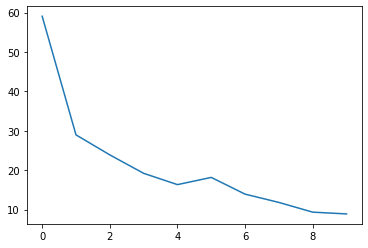

In [15]:
plt.plot(network.loss_history)
plt.show()

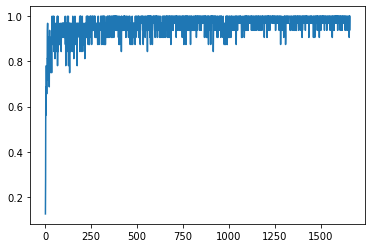

In [16]:
plt.plot(network.acc_history)
plt.show()

> #### Task:
- **Submit the predictions on the test dataset using your optimized model** <br/>
    For each record in the test set (`test.csv`), predict the value of the `category` variable.  You should submit a CSV file with a header row and one row per test entry. 

The file (`submissions.csv`) should have exactly 2 columns:

Column | Description
:---|:---
`img_id` | path of the product image
`category` | product category ('Accessories', 'Personal Care', 'Apparel', 'Footwear')

In [17]:
# test = pd.read_csv('test.csv')
# test.head()

In [18]:
# compute multiclass f1 score if you have label data

pred_list = torch.cat(pred_list, dim=0)
# label_list = torch.cat(label_list, dim=0)

# f1 = MulticlassF1Score(num_classes=4, average='weighted')
# f1(pred_list, label_list)

In [20]:
# decode the categories and add to test dataframe
img_dict = {0:'Accessories', 1:'Apparel', 2:'Footwear', 3:'Personal Care'}
test_category = []

for i, pred in enumerate(pred_list):
    test_category.append(img_dict[pred.item()])
    
test_data['category'] = test_category
print(test_data)

              img_id       category
0     test/45717.jpg  Personal Care
1     test/29453.jpg    Accessories
2     test/57800.jpg  Personal Care
3     test/40746.jpg    Accessories
4     test/53651.jpg    Accessories
...              ...            ...
2610  test/48206.jpg    Accessories
2611  test/54397.jpg    Accessories
2612  test/56571.jpg        Apparel
2613  test/52979.jpg        Apparel
2614  test/46926.jpg  Personal Care

[2614 rows x 2 columns]


KeyboardInterrupt: 

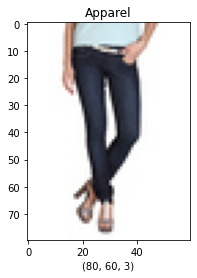

In [21]:
# Sanity check on answers, look through a few and make sure network is making 
# reasonable choices. 

testing_images = [mpimg.imread(file) for file in test_data['img_id']]
# look through images, their categories, and their shape
def visualize_data(image_set):
    for i, image in enumerate(image_set):
        plt.gca().clear()
        plt.imshow(image);
        plt.title(test_data.loc[i][1])
        plt.xlabel(image_set[i].shape)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(1.0)
        
visualize_data(testing_images)

In [22]:
submission_df = test_data

In [23]:
# Please not the size of the dataset is different by 1 from the original,
# as to save time I did not invoke any reshaping just for one image. 
# The index and image shape of incorrectly sized images is printed
# when running the create_dataset() function


#Submission
submission_df.to_csv('submissions.csv', index=False)